In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('supermarket.csv')
df.tail(3)

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
578079,200637,20061109,5,16,1,4.47,PRD0900396,CL00229,DEP00081,G00027,...,UM,NaN,994103100229855,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578080,200717,20070624,1,10,1,4.92,PRD0903065,CL00229,DEP00081,G00027,...,UM,YF,994106300437841,L,MM,Full Shop,Mixed,STORE00001,LS,E02
578081,200744,20071229,7,14,1,9.27,PRD0901923,CL00229,DEP00081,G00027,...,UM,NaN,994109000359411,L,MM,Top Up,Mixed,STORE00001,LS,E02


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 492494 non-null  object 
 12  CUST_PRICE_SENSITIVITY    492494 non-null  object 
 13  CUST_LIFESTAGE            433142 non-null  o

In [4]:
# Found missing values on CUST_CODE, CUST_PRICE_SENSITIVITY, CUST_LIFESTAGE columns
df.isna().sum()

SHOP_WEEK                        0
SHOP_DATE                        0
SHOP_WEEKDAY                     0
SHOP_HOUR                        0
QUANTITY                         0
SPEND                            0
PROD_CODE                        0
PROD_CODE_10                     0
PROD_CODE_20                     0
PROD_CODE_30                     0
PROD_CODE_40                     0
CUST_CODE                    85588
CUST_PRICE_SENSITIVITY       85588
CUST_LIFESTAGE              144940
BASKET_ID                        0
BASKET_SIZE                      0
BASKET_PRICE_SENSITIVITY         0
BASKET_TYPE                      0
BASKET_DOMINANT_MISSION          0
STORE_CODE                       0
STORE_FORMAT                     0
STORE_REGION                     0
dtype: int64

In [5]:
# Clean missing values
df.dropna(subset=['CUST_CODE'], inplace=True)
df['CUST_LIFESTAGE'] = df['CUST_LIFESTAGE'].fillna('XX')
df.isna().sum()

SHOP_WEEK                   0
SHOP_DATE                   0
SHOP_WEEKDAY                0
SHOP_HOUR                   0
QUANTITY                    0
SPEND                       0
PROD_CODE                   0
PROD_CODE_10                0
PROD_CODE_20                0
PROD_CODE_30                0
PROD_CODE_40                0
CUST_CODE                   0
CUST_PRICE_SENSITIVITY      0
CUST_LIFESTAGE              0
BASKET_ID                   0
BASKET_SIZE                 0
BASKET_PRICE_SENSITIVITY    0
BASKET_TYPE                 0
BASKET_DOMINANT_MISSION     0
STORE_CODE                  0
STORE_FORMAT                0
STORE_REGION                0
dtype: int64

In [6]:
df[['QUANTITY', 'SPEND']].describe().apply(lambda x: x.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
QUANTITY,492494.00000,1.52764,1.57281,1.00000,1.00000,1.00000,1.00000,129.00000
SPEND,492494.00000,1.92788,2.69127,0.01000,0.77000,1.24000,2.11000,346.46000


In [7]:
# clean data type
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['SHOP_MONTH'] = df['SHOP_DATE'].dt.to_period('m')

In [8]:
print(f"min date :{df['SHOP_DATE'].min()}")
print(f"max date :{df['SHOP_DATE'].max()}")

min date :2006-04-10 00:00:00
max date :2008-07-06 00:00:00


In [9]:
# filter churn customers out
# remove customers who inactive more than one month
print(f"before churn filter :{df['CUST_CODE'].nunique()}")

cust_active = list(df.loc[df['SHOP_MONTH'] >= (df['SHOP_MONTH'].max() - 1), :]['CUST_CODE'].unique())
df = df.loc[df['CUST_CODE'].isin(cust_active), :]

print(f"after churn filter :{df['CUST_CODE'].nunique()}")

before churn filter :3439
after churn filter :1026


In [10]:
# create feature df
df_clus = df[['CUST_CODE']].drop_duplicates().reset_index(drop=True)

df_clus = df_clus.merge(
    df.groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum'),
    date_min = ('SHOP_DATE', 'min'),
    date_max = ('SHOP_DATE', 'max')).reset_index().groupby('CUST_CODE').agg(bkt_size = ('spend', 'mean'), 
                                                                    num_trans = ('spend', 'count'),
                                                                    total_spend = ('spend', 'sum'),
                                                                    date_min = ('date_min', 'min'),
                                                                    date_max = ('date_max', 'max')),
    how='left', on='CUST_CODE')

df_clus = df_clus.merge(
    df.loc[df['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 3), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(bkt_size_3m = ('spend', 'mean'), 
                                                                    num_trans_3m = ('spend', 'count'),
                                                                    total_spend_3m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

df_clus = df_clus.merge(
    df.loc[df['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 6), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(bkt_size_6m = ('spend', 'mean'), 
                                                                    num_trans_6m = ('spend', 'count'),
                                                                    total_spend_6m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

# df_clus = df_clus.merge(
#     df_bkt.groupby('CUST_CODE').agg(date_min = ('SHOP_DATE', 'min'),
#                                     date_max = ('SHOP_DATE', 'max')),
#     how='left', on='CUST_CODE')
df_clus['tbp'] = (df_clus['date_max']-df_clus['date_min']).dt.days / df_clus['num_trans']
# df_clus.drop(columns=['date_max', 'date_min'], inplace=True)

df_clus['mem_dur'] = (df['SHOP_DATE'].max()-df_clus['date_min']).dt.days
df_clus['totspend/memdur'] = df_clus['total_spend']/df_clus['mem_dur']
df_clus['numtrans/memdur'] = df_clus['num_trans']/df_clus['mem_dur']

df_clus.drop(columns=['date_min', 'mem_dur', 'total_spend', 'num_trans', 'date_max'], inplace=True)

df_clus.tail(3)

,CUST_CODE,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,totspend/memdur,numtrans/memdur
1023,CUST0000691438,2.38,2.38,1,2.38,2.38,1,2.38,391.0,0.006064,0.002548
1024,CUST0000031949,1.08,1.08,1,1.08,1.08,1,1.08,143.0,0.006901,0.006390
1025,CUST0000950079,0.51,0.51,1,0.51,0.51,1,0.51,381.5,0.001296,0.002541


In [11]:
df_clus.describe()

,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,totspend/memdur,numtrans/memdur
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,15.207934,14.960315,4.931774,73.015780,15.067712,10.860624,157.185117,51.253703,1.049391,0.072110
std,12.862635,15.164885,6.351741,104.860534,14.118479,14.821773,224.949731,65.775567,1.394048,0.091749
min,0.080000,0.080000,1.000000,0.080000,0.080000,1.000000,0.080000,1.310897,0.000483,0.002478
25%,6.401739,4.341250,1.000000,8.712500,5.161964,2.000000,17.235000,10.632432,0.145424,0.014815
50%,11.931667,10.496667,3.000000,30.735000,11.266000,5.000000,59.410000,26.295699,0.488814,0.037491
75%,20.984542,20.265000,6.000000,92.022500,20.345192,14.000000,204.622500,65.125000,1.346910,0.092994
max,133.080000,134.050000,62.000000,885.630000,133.080000,129.000000,1893.210000,402.500000,10.124279,0.762836


In [12]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026 entries, 0 to 1025
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CUST_CODE        1026 non-null   object 
 1   bkt_size         1026 non-null   float64
 2   bkt_size_3m      1026 non-null   float64
 3   num_trans_3m     1026 non-null   int64  
 4   total_spend_3m   1026 non-null   float64
 5   bkt_size_6m      1026 non-null   float64
 6   num_trans_6m     1026 non-null   int64  
 7   total_spend_6m   1026 non-null   float64
 8   tbp              1026 non-null   float64
 9   totspend/memdur  1026 non-null   float64
 10  numtrans/memdur  1026 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 96.2+ KB


In [156]:
# df_group = df.groupby('CUST_CODE').agg({'SHOP_DATE': lambda x: (df['SHOP_DATE'].max() - x.max()).days,
#                             'SPEND': lambda x: x.sum(),
#                             'BASKET_ID': lambda x: x.nunique()
#                             }).reset_index()

# df_group.columns=['CUST_CODE','recency','total_spent', 'num_bkt']

# # Average Order Value
# df_group['bkt_size']=df_group['total_spent']/df_group['num_bkt']

# # Purchase Frequency
# purchase_frequency=sum(df_group['num_bkt'])/df_group.shape[0]

# # Repeat Rate
# repeat_rate=df_group[df_group.num_bkt > 1].shape[0]/df_group.shape[0]

# #Churn Rate
# churn_rate=1-repeat_rate

# # Customer Value
# df_group['clv']=(df_group['bkt_size']*purchase_frequency)/churn_rate

# # Time Between Purchase
# customer_lifespan = (df['SHOP_DATE'].max() - df['SHOP_DATE'].min()).days
# df_group['tbp'] = customer_lifespan/df_group['num_bkt']

# df_group.tail(3)

In [13]:
X = df_clus.drop(columns='CUST_CODE')

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

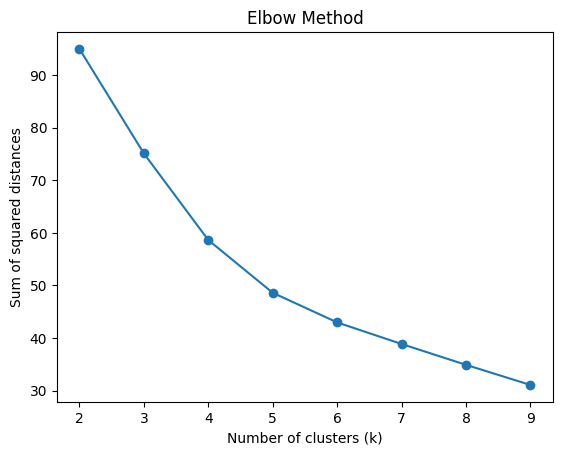

Silhouette Score k=2 : 0.48930619806249287
Silhouette Score k=3 : 0.38830874226771905
Silhouette Score k=4 : 0.3803483318283402
Silhouette Score k=5 : 0.36485906799922296


In [14]:
### Elbow
k_values = range(2, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

### Silhouette
for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Print the silhouette score
    print(f"Silhouette Score k={k} : {silhouette_avg}")

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_clus['Cluster'] = labels
df_clus.tail(3)

,CUST_CODE,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,totspend/memdur,numtrans/memdur,Cluster
1023,CUST0000691438,2.38,2.38,1,2.38,2.38,1,2.38,391.0,0.006064,0.002548,1
1024,CUST0000031949,1.08,1.08,1,1.08,1.08,1,1.08,143.0,0.006901,0.006390,1
1025,CUST0000950079,0.51,0.51,1,0.51,0.51,1,0.51,381.5,0.001296,0.002541,1


In [16]:
# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Print the feature rankings
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i+1}: Feature {df_clus.columns[idx+1]}, Importance score: {importance_scores[idx]}")

Rank 1: Feature tbp, Importance score: 0.19413539234714441
Rank 2: Feature numtrans/memdur, Importance score: 0.1623756992377759
Rank 3: Feature totspend/memdur, Importance score: 0.11962189081480024
Rank 4: Feature total_spend_3m, Importance score: 0.09618439066727684
Rank 5: Feature bkt_size_3m, Importance score: 0.09322823097207258
Rank 6: Feature bkt_size_6m, Importance score: 0.08783330860939746
Rank 7: Feature bkt_size, Importance score: 0.07351550478383115
Rank 8: Feature num_trans_3m, Importance score: 0.06712790250084855
Rank 9: Feature total_spend_6m, Importance score: 0.05609454425672697
Rank 10: Feature num_trans_6m, Importance score: 0.04988313581012587


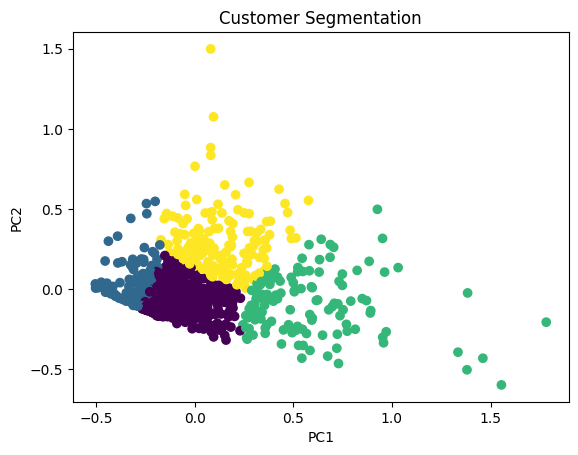

In [17]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), title='Labels')

# Show the plot
plt.show()

In [18]:
df_clus['Cluster'].value_counts()

0    603
3    160
1    136
2    127
Name: Cluster, dtype: int64

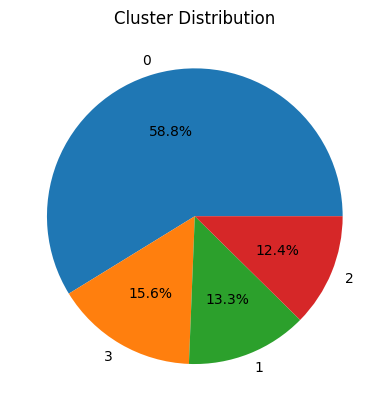

In [19]:
cluster_counts = df_clus['Cluster'].value_counts()

# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

bkt_size
The ANOVA p-value is: F_onewayResult(statistic=321.0435195999885, pvalue=8.120296506210474e-147)


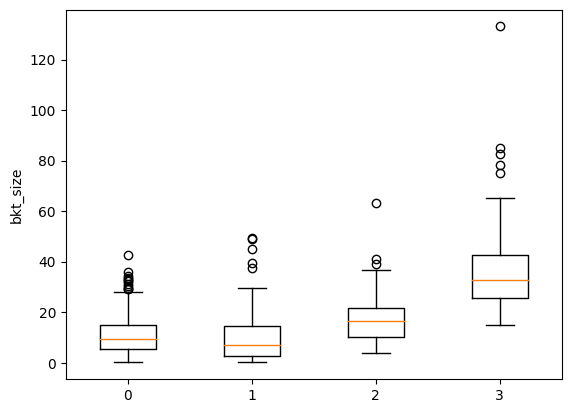

bkt_size_3m
The ANOVA p-value is: F_onewayResult(statistic=374.3082373998439, pvalue=5.555044346744669e-164)


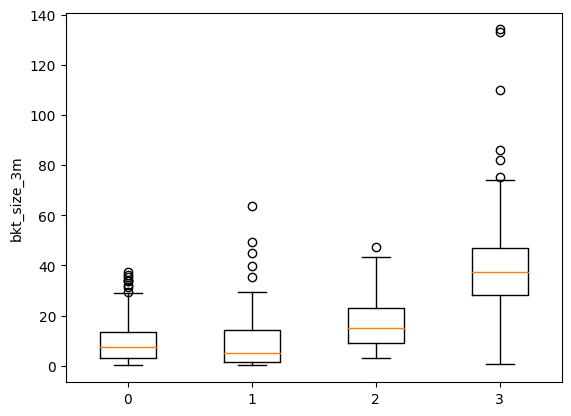

num_trans_3m
The ANOVA p-value is: F_onewayResult(statistic=501.3204476632506, pvalue=3.048182950402568e-200)


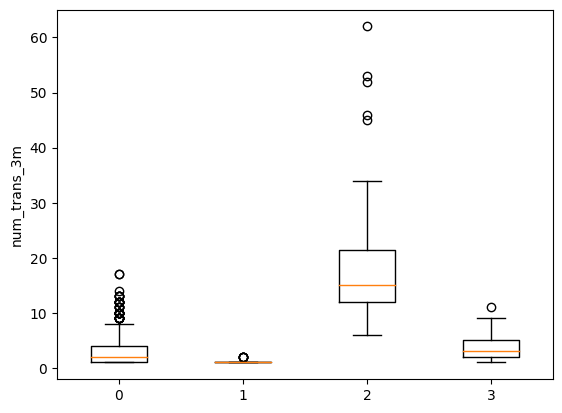

total_spend_3m
The ANOVA p-value is: F_onewayResult(statistic=540.3183777236059, pvalue=2.7708723626556827e-210)


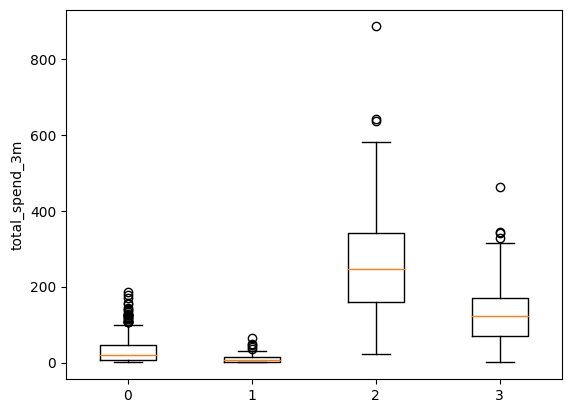

bkt_size_6m
The ANOVA p-value is: F_onewayResult(statistic=404.36099282451266, pvalue=4.120892892140325e-173)


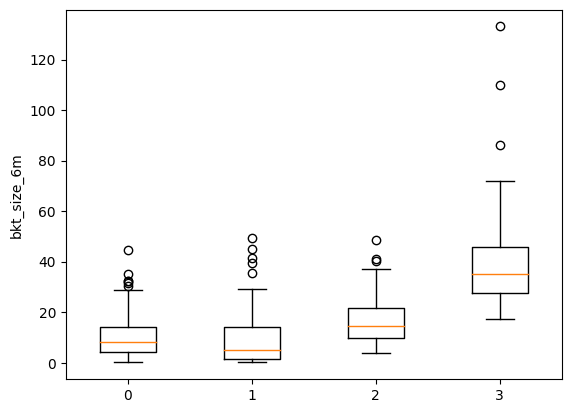

num_trans_6m
The ANOVA p-value is: F_onewayResult(statistic=510.55805994735766, pvalue=1.1590759913334168e-202)


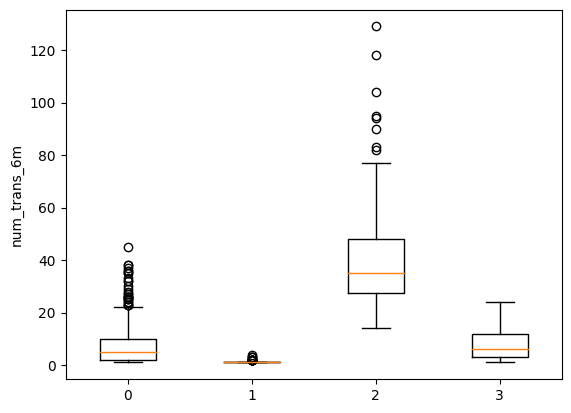

total_spend_6m
The ANOVA p-value is: F_onewayResult(statistic=618.3316062401059, pvalue=4.202012075586957e-229)


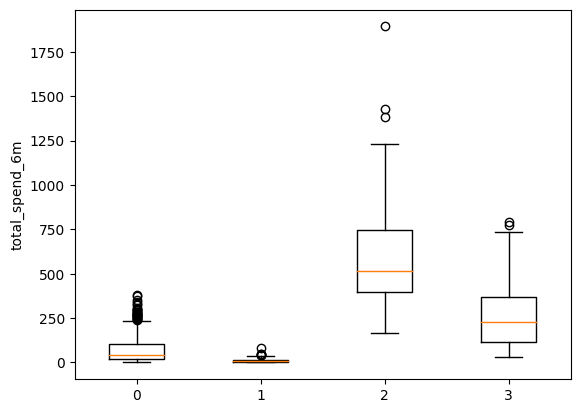

tbp
The ANOVA p-value is: F_onewayResult(statistic=691.4354865058647, pvalue=2.129915324781601e-245)


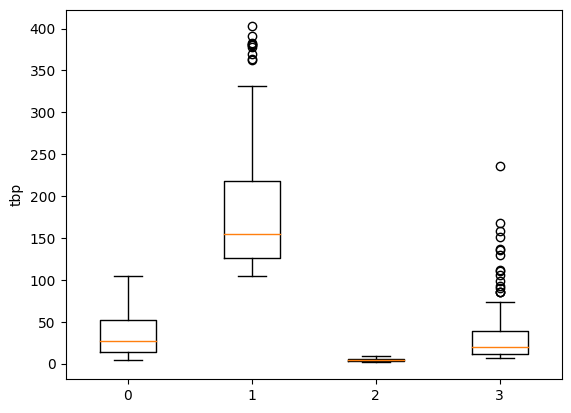

totspend/memdur
The ANOVA p-value is: F_onewayResult(statistic=660.2474405875762, pvalue=1.3631200660041395e-238)


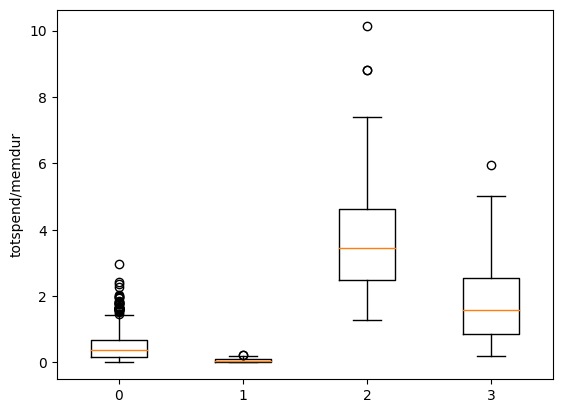

numtrans/memdur
The ANOVA p-value is: F_onewayResult(statistic=540.9182156998178, pvalue=1.957305562915075e-210)


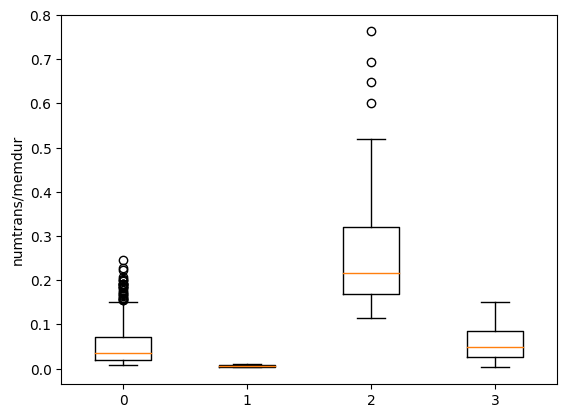

In [20]:
df_clus['Cluster'] = df_clus['Cluster'].astype(str)
num_var = df_clus.select_dtypes(include=['float64', 'int64']).columns.to_list()

for i in num_var:
    fig, ax = plt.subplots()
    ax.boxplot([df_clus[df_clus['Cluster'] == '0'][i],
                df_clus[df_clus['Cluster'] == '1'][i],
                df_clus[df_clus['Cluster'] == '2'][i],
                df_clus[df_clus['Cluster'] == '3'][i]
                ])
    ax.set_xticklabels(['0', '1','2','3'])
    ax.set_ylabel(i)

    p_value = f_oneway(df_clus[df_clus['Cluster'] == '0'][i],
                      df_clus[df_clus['Cluster'] == '1'][i],
                      df_clus[df_clus['Cluster'] == '2'][i],
                      df_clus[df_clus['Cluster'] == '3'][i]
                      )

    print(i)
    print("The ANOVA p-value is:", p_value)
    plt.show()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       127
           1       0.93      1.00      0.96        25
           2       0.96      1.00      0.98        27
           3       0.96      0.96      0.96        27

    accuracy                           0.98       206
   macro avg       0.96      0.98      0.97       206
weighted avg       0.98      0.98      0.98       206



In [22]:
df_seg = df.merge(df_clus[['CUST_CODE', 'Cluster']], on='CUST_CODE', how='left')

In [23]:
import os

df_list = [df_seg[df_seg['Cluster'] == '0'], 
           df_seg[df_seg['Cluster'] == '1'],
           df_seg[df_seg['Cluster'] == '2'],
           df_seg[df_seg['Cluster'] == '3']]

for i, df in enumerate(df_list):
    df_prep = df_seg.sort_values(by='SHOP_DATE')
    df_prep = df_prep[['BASKET_ID', 'PROD_CODE_10']].drop_duplicates()
    df_group = df_prep.groupby(['BASKET_ID'])['PROD_CODE_10'].apply('|'.join).reset_index()

    df_trans = df_group['PROD_CODE_10'].str.get_dummies('|').astype(pd.SparseDtype('bool'))
    print(f"df_trans_{i} shape:", df_trans.shape)

    frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
    frequent_itemsets.sort_values('support', ascending=False, inplace=True)

    asso_rule = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
    asso_rule.sort_values('confidence', ascending=False, inplace=True)

    print(f"Association rules for df_cluster_{i}:")
    display(asso_rule)

    # filename = f"asso_rule_df_cluster_{i}.csv"
    # asso_rule.to_csv(filename, index=False)
    # print(f"Association rules for df_cluster_{i} saved to {os.getcwd()}/{filename}")

df_trans_0 shape: (55203, 249)
Association rules for df_cluster_0:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(CL00070),(CL00063),0.157165,0.292212,0.068801,0.437759,1.498086,0.022875,1.258869,0.394480
12,(CL00043),(CL00031),0.117584,0.212851,0.051048,0.434140,2.039643,0.026020,1.391066,0.577639
5,(CL00045),(CL00063),0.159031,0.292212,0.067243,0.422827,1.446986,0.020772,1.226301,0.367324
15,(CL00067),(CL00063),0.118707,0.292212,0.050088,0.421944,1.443964,0.015400,1.224428,0.348876
6,(CL00045),(CL00031),0.159031,0.212851,0.064978,0.408589,1.919602,0.031128,1.330967,0.569651
8,(CL00070),(CL00031),0.157165,0.212851,0.063565,0.404449,1.900153,0.030113,1.321716,0.562064
1,(CL00031),(CL00063),0.212851,0.292212,0.083963,0.394468,1.349936,0.021765,1.168869,0.329320
10,(CL00222),(CL00063),0.146532,0.292212,0.051428,0.350970,1.201080,0.008610,1.090532,0.196160
7,(CL00031),(CL00045),0.212851,0.159031,0.064978,0.305277,1.919602,0.031128,1.210509,0.608599
9,(CL00031),(CL00070),0.212851,0.157165,0.063565,0.298638,1.900153,0.030113,1.201712,0.601826


df_trans_1 shape: (55203, 249)
Association rules for df_cluster_1:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(CL00070),(CL00063),0.157165,0.292212,0.068801,0.437759,1.498086,0.022875,1.258869,0.394480
12,(CL00043),(CL00031),0.117584,0.212851,0.051048,0.434140,2.039643,0.026020,1.391066,0.577639
5,(CL00045),(CL00063),0.159031,0.292212,0.067243,0.422827,1.446986,0.020772,1.226301,0.367324
15,(CL00067),(CL00063),0.118707,0.292212,0.050088,0.421944,1.443964,0.015400,1.224428,0.348876
6,(CL00045),(CL00031),0.159031,0.212851,0.064978,0.408589,1.919602,0.031128,1.330967,0.569651
8,(CL00070),(CL00031),0.157165,0.212851,0.063565,0.404449,1.900153,0.030113,1.321716,0.562064
1,(CL00031),(CL00063),0.212851,0.292212,0.083963,0.394468,1.349936,0.021765,1.168869,0.329320
10,(CL00222),(CL00063),0.146532,0.292212,0.051428,0.350970,1.201080,0.008610,1.090532,0.196160
7,(CL00031),(CL00045),0.212851,0.159031,0.064978,0.305277,1.919602,0.031128,1.210509,0.608599
9,(CL00031),(CL00070),0.212851,0.157165,0.063565,0.298638,1.900153,0.030113,1.201712,0.601826


df_trans_2 shape: (55203, 249)
Association rules for df_cluster_2:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(CL00070),(CL00063),0.157165,0.292212,0.068801,0.437759,1.498086,0.022875,1.258869,0.394480
12,(CL00043),(CL00031),0.117584,0.212851,0.051048,0.434140,2.039643,0.026020,1.391066,0.577639
5,(CL00045),(CL00063),0.159031,0.292212,0.067243,0.422827,1.446986,0.020772,1.226301,0.367324
15,(CL00067),(CL00063),0.118707,0.292212,0.050088,0.421944,1.443964,0.015400,1.224428,0.348876
6,(CL00045),(CL00031),0.159031,0.212851,0.064978,0.408589,1.919602,0.031128,1.330967,0.569651
8,(CL00070),(CL00031),0.157165,0.212851,0.063565,0.404449,1.900153,0.030113,1.321716,0.562064
1,(CL00031),(CL00063),0.212851,0.292212,0.083963,0.394468,1.349936,0.021765,1.168869,0.329320
10,(CL00222),(CL00063),0.146532,0.292212,0.051428,0.350970,1.201080,0.008610,1.090532,0.196160
7,(CL00031),(CL00045),0.212851,0.159031,0.064978,0.305277,1.919602,0.031128,1.210509,0.608599
9,(CL00031),(CL00070),0.212851,0.157165,0.063565,0.298638,1.900153,0.030113,1.201712,0.601826


df_trans_3 shape: (55203, 249)
Association rules for df_cluster_3:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(CL00070),(CL00063),0.157165,0.292212,0.068801,0.437759,1.498086,0.022875,1.258869,0.394480
12,(CL00043),(CL00031),0.117584,0.212851,0.051048,0.434140,2.039643,0.026020,1.391066,0.577639
5,(CL00045),(CL00063),0.159031,0.292212,0.067243,0.422827,1.446986,0.020772,1.226301,0.367324
15,(CL00067),(CL00063),0.118707,0.292212,0.050088,0.421944,1.443964,0.015400,1.224428,0.348876
6,(CL00045),(CL00031),0.159031,0.212851,0.064978,0.408589,1.919602,0.031128,1.330967,0.569651
8,(CL00070),(CL00031),0.157165,0.212851,0.063565,0.404449,1.900153,0.030113,1.321716,0.562064
1,(CL00031),(CL00063),0.212851,0.292212,0.083963,0.394468,1.349936,0.021765,1.168869,0.329320
10,(CL00222),(CL00063),0.146532,0.292212,0.051428,0.350970,1.201080,0.008610,1.090532,0.196160
7,(CL00031),(CL00045),0.212851,0.159031,0.064978,0.305277,1.919602,0.031128,1.210509,0.608599
9,(CL00031),(CL00070),0.212851,0.157165,0.063565,0.298638,1.900153,0.030113,1.201712,0.601826


## Clustering for Another Segment

In [211]:
def create_proportion(df, col):
    # Group by ID and count unique strings
    grouped = df.groupby('CUST_CODE')[col].value_counts().unstack(fill_value=0)

    # Calculate total string counts for each ID
    grouped['Total'] = grouped.sum(axis=1)

    # Calculate proportion columns
    unique_strings = grouped.columns[:-1]
    proportion_columns = [f'{col}_{string}' for string in unique_strings]
    grouped[proportion_columns] = grouped[unique_strings].div(grouped['Total'], axis=0)

    # Reset the index if desired
    grouped.reset_index(inplace=True)

    # Select only the 'ID' column and proportion columns
    result = grouped[['CUST_CODE'] + proportion_columns]

    return result

In [182]:
df_clus1 = df[['CUST_CODE']].drop_duplicates().reset_index(drop=True)
df_bkt = df.drop_duplicates(subset=['CUST_CODE', 'BASKET_ID'])

# df_clus1 = df_clus1.merge(
#     create_proportion(df_bkt, 'CUST_LIFESTAGE'), 
#     how='left', on='CUST_CODE')

df_clus1 = df_clus1.merge(
    create_proportion(df_bkt, 'BASKET_TYPE'), 
    how='left', on='CUST_CODE')

df_clus1 = df_clus1.merge(
    create_proportion(df_bkt, 'BASKET_DOMINANT_MISSION'), 
    how='left', on='CUST_CODE')

df_clus1 = df_clus1.merge(
    create_proportion(df_bkt, 'BASKET_PRICE_SENSITIVITY'), 
    how='left', on='CUST_CODE')

# df_clus1 = df_clus1.merge(
#     create_proportion(df_bkt, 'BASKET_SIZE'), 
#     how='left', on='CUST_CODE')

df_clus1.tail(3)

,CUST_CODE,BASKET_TYPE_Full Shop,BASKET_TYPE_Small Shop,BASKET_TYPE_Top Up,BASKET_TYPE_XX,BASKET_DOMINANT_MISSION_Fresh,BASKET_DOMINANT_MISSION_Grocery,BASKET_DOMINANT_MISSION_Mixed,BASKET_DOMINANT_MISSION_Nonfood,BASKET_DOMINANT_MISSION_XX,BASKET_PRICE_SENSITIVITY_LA,BASKET_PRICE_SENSITIVITY_MM,BASKET_PRICE_SENSITIVITY_UM,BASKET_PRICE_SENSITIVITY_XX
1023,CUST0000691438,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1024,CUST0000031949,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1025,CUST0000950079,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [183]:
X = df_clus1.drop(columns='CUST_CODE')

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

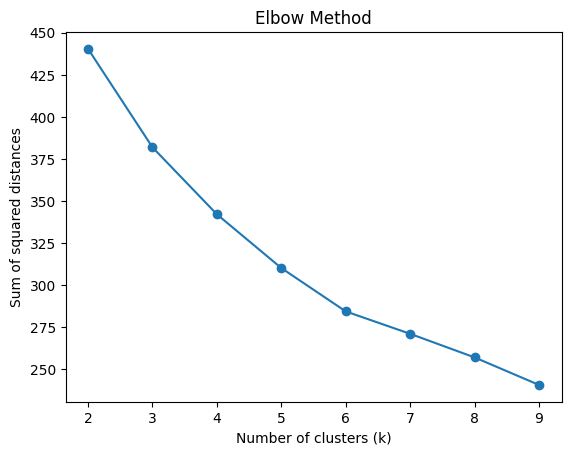

Silhouette Score k=2 : 0.21711904110479666
Silhouette Score k=3 : 0.19289326945954896
Silhouette Score k=4 : 0.18360142929149306
Silhouette Score k=5 : 0.1919780484897267


In [186]:
### Elbow
k_values = range(2, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

### Silhouette
for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Print the silhouette score
    print(f"Silhouette Score k={k} : {silhouette_avg}")

In [187]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_clus1['Cluster'] = labels
df_clus1.tail(3)

,CUST_CODE,BASKET_TYPE_Full Shop,BASKET_TYPE_Small Shop,BASKET_TYPE_Top Up,BASKET_TYPE_XX,BASKET_DOMINANT_MISSION_Fresh,BASKET_DOMINANT_MISSION_Grocery,BASKET_DOMINANT_MISSION_Mixed,BASKET_DOMINANT_MISSION_Nonfood,BASKET_DOMINANT_MISSION_XX,BASKET_PRICE_SENSITIVITY_LA,BASKET_PRICE_SENSITIVITY_MM,BASKET_PRICE_SENSITIVITY_UM,BASKET_PRICE_SENSITIVITY_XX,Cluster
1023,CUST0000691438,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
1024,CUST0000031949,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
1025,CUST0000950079,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [184]:
# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Print the feature rankings
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i+1}: Feature {df_clus1.columns[idx+1]}, Importance score: {importance_scores[idx]}")

Rank 1: Feature BASKET_DOMINANT_MISSION_Fresh, Importance score: 0.10053194046840881
Rank 2: Feature BASKET_DOMINANT_MISSION_Mixed, Importance score: 0.09892588675954946
Rank 3: Feature BASKET_PRICE_SENSITIVITY_MM, Importance score: 0.09791727317395288
Rank 4: Feature BASKET_DOMINANT_MISSION_Grocery, Importance score: 0.09678948215494661
Rank 5: Feature BASKET_TYPE_Top Up, Importance score: 0.09573467102801322
Rank 6: Feature BASKET_PRICE_SENSITIVITY_LA, Importance score: 0.09368519717494977
Rank 7: Feature BASKET_TYPE_Small Shop, Importance score: 0.09342534399725658
Rank 8: Feature BASKET_PRICE_SENSITIVITY_UM, Importance score: 0.08791802449686031
Rank 9: Feature BASKET_DOMINANT_MISSION_Nonfood, Importance score: 0.0748118027313434
Rank 10: Feature BASKET_TYPE_Full Shop, Importance score: 0.07107150259802465
Rank 11: Feature BASKET_PRICE_SENSITIVITY_XX, Importance score: 0.045079138052179196
Rank 12: Feature BASKET_DOMINANT_MISSION_XX, Importance score: 0.022116977357105033
Rank 13: 

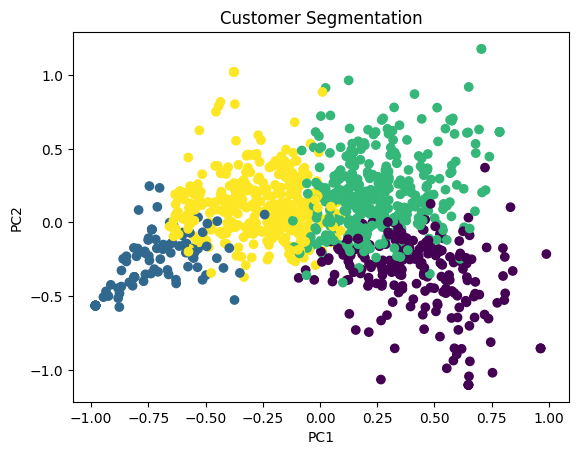

In [188]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), title='Labels')

# Show the plot
plt.show()

In [196]:
# df_clus1['Cluster'] = df_clus1['Cluster'].astype(str)
# num_var = df_clus1.select_dtypes(include=['float64', 'int64']).columns.to_list()

# for i in num_var:
#     fig, ax = plt.subplots()
#     ax.boxplot([df_clus1[df_clus1['Cluster'] == '0'][i],
#                 df_clus1[df_clus1['Cluster'] == '1'][i],
#                 df_clus1[df_clus1['Cluster'] == '2'][i],
#                 df_clus1[df_clus1['Cluster'] == '3'][i]
#                 ])
#     ax.set_xticklabels(['0', '1', '2', '3'])
#     ax.set_ylabel(i)

#     p_value = f_oneway(df_clus1[df_clus1['Cluster'] == '0'][i],
#                         df_clus1[df_clus1['Cluster'] == '1'][i],
#                         df_clus1[df_clus1['Cluster'] == '2'][i],
#                         df_clus1[df_clus1['Cluster'] == '3'][i]
#                       )

#     print(i)
#     print("The ANOVA p-value is:", p_value)
#     plt.show()

## 2nd Time Clustering

In [26]:
df_seg1 = df_seg.loc[df_seg['Cluster']=='0', :]

# create feature df
df_clus1 = df_seg1[['CUST_CODE']].drop_duplicates().reset_index(drop=True)

df_clus1 = df_clus1.merge(
    df_seg1.groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum'),
    date_min = ('SHOP_DATE', 'min'),
    date_max = ('SHOP_DATE', 'max')).reset_index().groupby('CUST_CODE').agg(bkt_size = ('spend', 'mean'), 
                                                                    num_trans = ('spend', 'count'),
                                                                    total_spend = ('spend', 'sum'),
                                                                    date_min = ('date_min', 'min'),
                                                                    date_max = ('date_max', 'max')),
    how='left', on='CUST_CODE')

df_clus1 = df_clus1.merge(
    df_seg1.loc[df_seg1['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 3), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(bkt_size_3m = ('spend', 'mean'), 
                                                                    num_trans_3m = ('spend', 'count'),
                                                                    total_spend_3m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

df_clus1 = df_clus1.merge(
    df_seg1.loc[df_seg1['SHOP_MONTH'] > (df['SHOP_MONTH'].max() - 6), :].groupby(['CUST_CODE', 'BASKET_ID']).agg(
    spend = ('SPEND', 'sum')).reset_index().groupby('CUST_CODE').agg(bkt_size_6m = ('spend', 'mean'), 
                                                                    num_trans_6m = ('spend', 'count'),
                                                                    total_spend_6m = ('spend', 'sum')),
    how='left', on='CUST_CODE')

df_clus1['tbp'] = (df_clus1['date_max']-df_clus1['date_min']).dt.days / df_clus1['num_trans']
df_clus1['mem_dur'] = (df['SHOP_DATE'].max()-df_clus1['date_min']).dt.days
df_clus1['totspend/memdur'] = df_clus1['total_spend']/df_clus1['mem_dur']
df_clus1['numtrans/memdur'] = df_clus1['num_trans']/df_clus1['mem_dur']

df_clus1.drop(columns=['date_min', 'mem_dur', 'total_spend', 'num_trans', 'date_max'], inplace=True)

df_clus1.tail(3)

,CUST_CODE,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,totspend/memdur,numtrans/memdur
600,CUST0000201555,2.060000,2.06,1,2.06,2.06,1,2.06,71.5,0.023953,0.011628
601,CUST0000817762,1.956667,2.38,1,2.38,2.38,1,2.38,55.0,0.031559,0.016129
602,CUST0000090124,3.210000,3.21,1,3.21,3.21,2,6.42,53.5,0.060000,0.018692


In [27]:
df_clus1.describe()

,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,totspend/memdur,numtrans/memdur
count,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,10.608954,9.222219,3.431177,30.976302,9.792420,7.529022,70.585489,35.199871,0.514305,0.052115
std,6.791434,7.310599,2.818394,31.795778,7.017615,7.277399,74.238783,25.985837,0.477070,0.044441
min,0.235556,0.150000,1.000000,0.150000,0.150000,1.000000,0.150000,3.975124,0.002826,0.008721
25%,5.509210,3.116667,1.000000,7.120000,4.274167,2.000000,17.490000,13.699519,0.159235,0.018616
50%,9.376667,7.420000,2.000000,20.730000,8.310000,5.000000,42.240000,27.250000,0.365779,0.035616
75%,14.856167,13.516667,4.000000,44.860000,14.166250,10.000000,104.530000,52.457576,0.673619,0.072210
max,42.637000,37.210000,17.000000,184.680000,44.666667,45.000000,382.620000,104.428571,2.962029,0.246626


In [28]:
X = df_clus1.drop(columns='CUST_CODE')

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

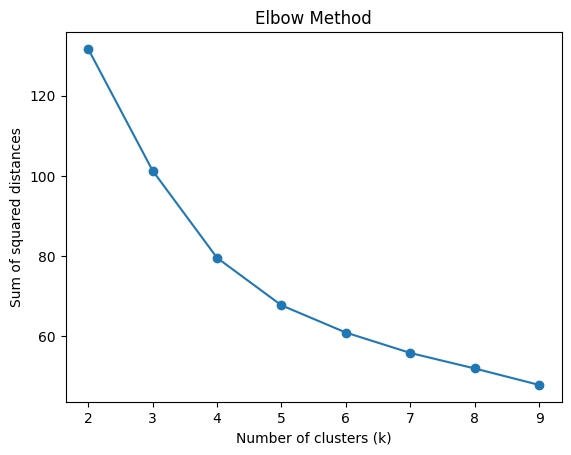

Silhouette Score k=2 : 0.36016168528615816
Silhouette Score k=3 : 0.30313239915156814
Silhouette Score k=4 : 0.2992806814274062
Silhouette Score k=5 : 0.30692662361081


In [29]:
### Elbow
k_values = range(2, 10)
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

### Silhouette
for k in range(2, 6):
    # Create a KMeans object and fit the data
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)

    # Get the cluster labels for each sample
    labels = kmeans.labels_

    # Calculate silhouette score
    silhouette_avg = silhouette_score(X, labels)

    # Print the silhouette score
    print(f"Silhouette Score k={k} : {silhouette_avg}")

In [30]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
df_clus1['Cluster'] = labels
df_clus1.tail(3)

,CUST_CODE,bkt_size,bkt_size_3m,num_trans_3m,total_spend_3m,bkt_size_6m,num_trans_6m,total_spend_6m,tbp,totspend/memdur,numtrans/memdur,Cluster
600,CUST0000201555,2.060000,2.06,1,2.06,2.06,1,2.06,71.5,0.023953,0.011628,1
601,CUST0000817762,1.956667,2.38,1,2.38,2.38,1,2.38,55.0,0.031559,0.016129,1
602,CUST0000090124,3.210000,3.21,1,3.21,3.21,2,6.42,53.5,0.060000,0.018692,1


In [31]:
# Create a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier on your data
clf.fit(X, labels)

# Get the feature importance scores
importance_scores = clf.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Print the feature rankings
for i, idx in enumerate(sorted_indices):
    print(f"Rank {i+1}: Feature {df_clus1.columns[idx+1]}, Importance score: {importance_scores[idx]}")

Rank 1: Feature bkt_size_6m, Importance score: 0.16732359180366096
Rank 2: Feature total_spend_6m, Importance score: 0.13120158517741543
Rank 3: Feature bkt_size_3m, Importance score: 0.12179165453496184
Rank 4: Feature numtrans/memdur, Importance score: 0.11974971627150227
Rank 5: Feature tbp, Importance score: 0.1084245534305537
Rank 6: Feature total_spend_3m, Importance score: 0.10507386900755382
Rank 7: Feature num_trans_6m, Importance score: 0.0876155366519819
Rank 8: Feature bkt_size, Importance score: 0.07279347625804235
Rank 9: Feature totspend/memdur, Importance score: 0.048548777608402524
Rank 10: Feature num_trans_3m, Importance score: 0.03747723925592518


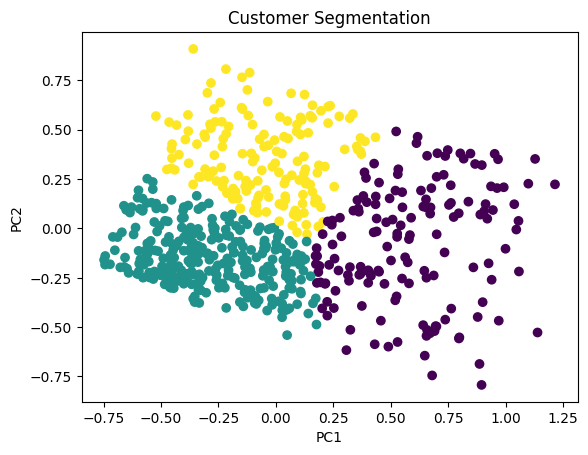

In [32]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Customer Segmentation')

# plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), title='Labels')

# Show the plot
plt.show()

In [33]:
df_clus1['Cluster'].value_counts()

1    290
2    159
0    154
Name: Cluster, dtype: int64

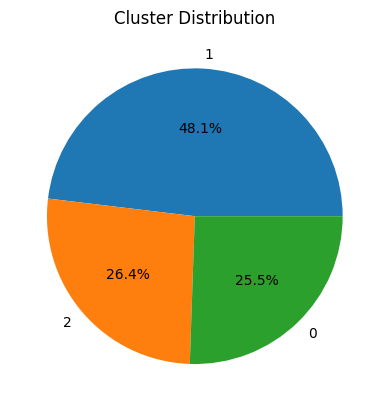

In [34]:
cluster_counts = df_clus1['Cluster'].value_counts()

# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%')

# Add a title to the chart
plt.title('Cluster Distribution')

# Display the chart
plt.show()

bkt_size
The ANOVA p-value is: F_onewayResult(statistic=237.12531169201478, pvalue=1.2992442468172236e-76)


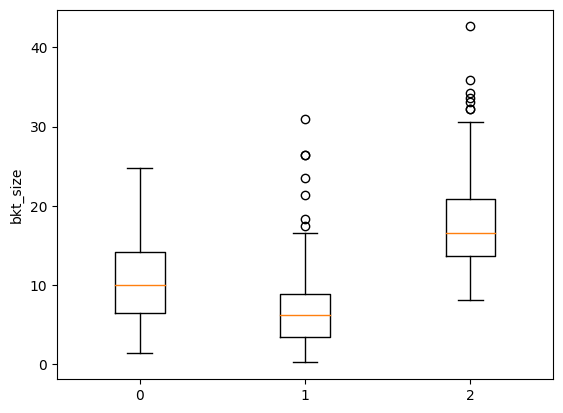

bkt_size_3m
The ANOVA p-value is: F_onewayResult(statistic=336.334295837571, pvalue=1.0734386849186224e-98)


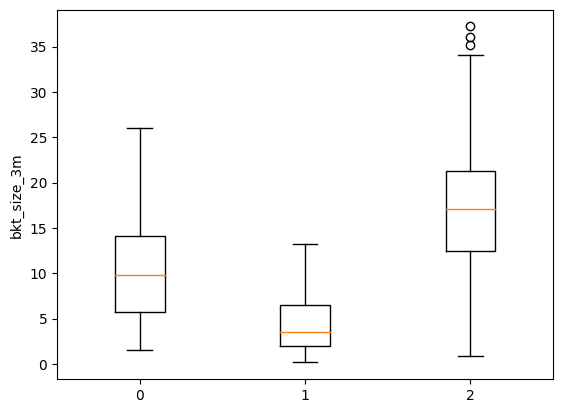

num_trans_3m
The ANOVA p-value is: F_onewayResult(statistic=386.67445241161306, pvalue=1.2915447541406295e-108)


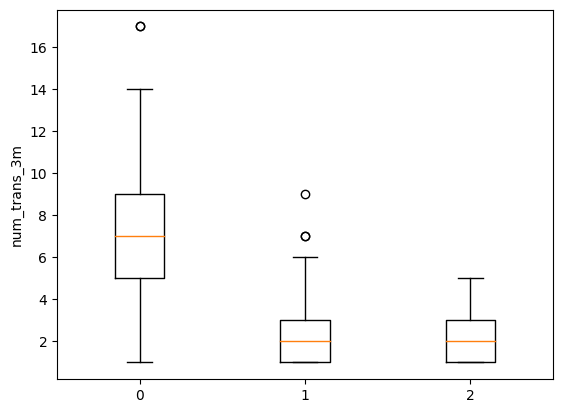

total_spend_3m
The ANOVA p-value is: F_onewayResult(statistic=313.2932111177696, pvalue=6.853765412454679e-94)


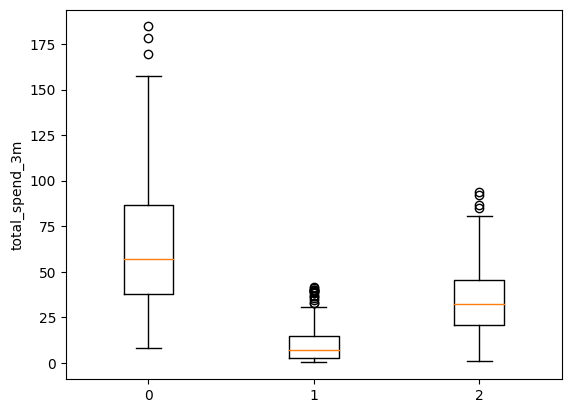

bkt_size_6m
The ANOVA p-value is: F_onewayResult(statistic=391.6515741906444, pvalue=1.479672145319872e-109)


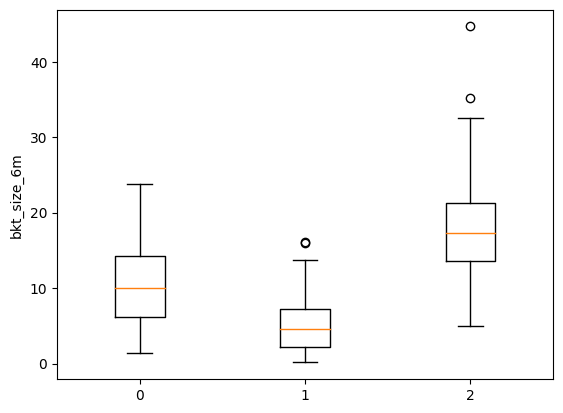

num_trans_6m
The ANOVA p-value is: F_onewayResult(statistic=466.490078803184, pvalue=6.087164769876382e-123)


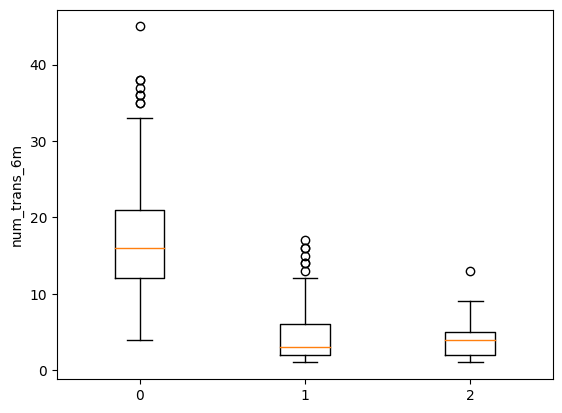

total_spend_6m
The ANOVA p-value is: F_onewayResult(statistic=431.5842966310585, pvalue=7.195549550771315e-117)


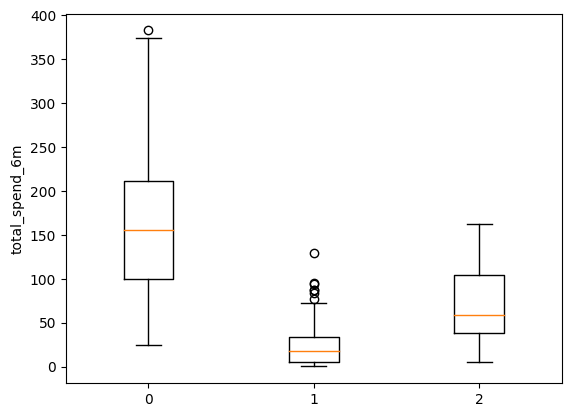

tbp
The ANOVA p-value is: F_onewayResult(statistic=142.68730733314501, pvalue=2.0288754046820377e-51)


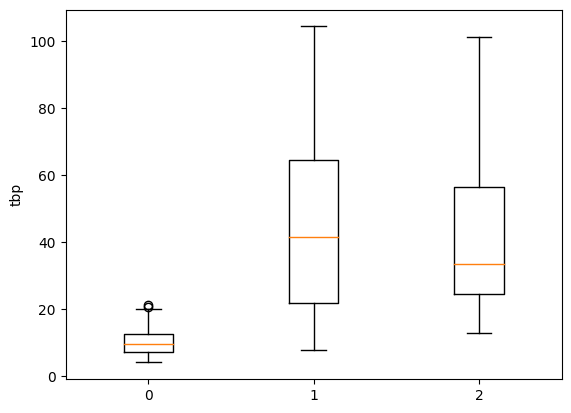

totspend/memdur
The ANOVA p-value is: F_onewayResult(statistic=356.1087961202917, pvalue=1.1056517732049703e-102)


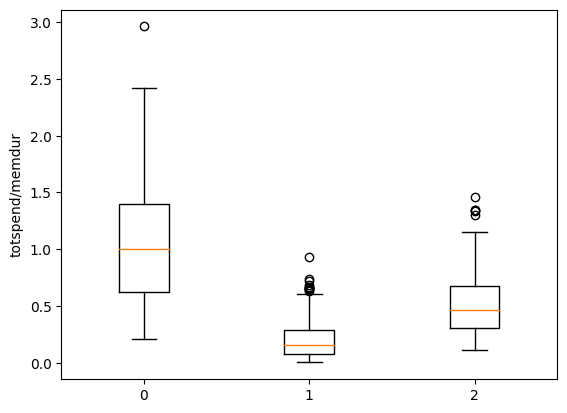

numtrans/memdur
The ANOVA p-value is: F_onewayResult(statistic=485.4309478737571, pvalue=4.017663498854253e-126)


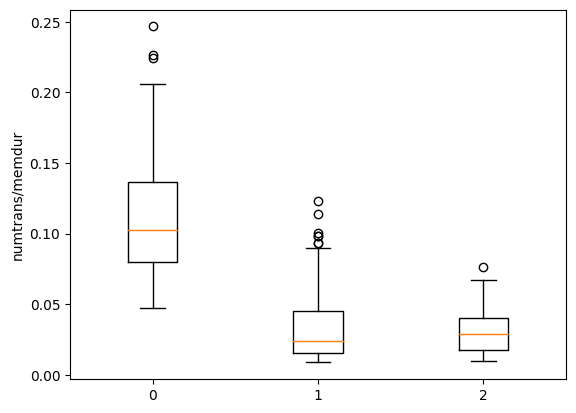

In [35]:
df_clus1['Cluster'] = df_clus1['Cluster'].astype(str)
num_var = df_clus1.select_dtypes(include=['float64', 'int64']).columns.to_list()

for i in num_var:
    fig, ax = plt.subplots()
    ax.boxplot([df_clus1[df_clus1['Cluster'] == '0'][i],
                df_clus1[df_clus1['Cluster'] == '1'][i],
                df_clus1[df_clus1['Cluster'] == '2'][i]
                ])
    ax.set_xticklabels(['0', '1','2'])
    ax.set_ylabel(i)

    p_value = f_oneway(df_clus1[df_clus1['Cluster'] == '0'][i],
                        df_clus1[df_clus1['Cluster'] == '1'][i],
                        df_clus1[df_clus1['Cluster'] == '2'][i]
                      )

    print(i)
    print("The ANOVA p-value is:", p_value)
    plt.show()